In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from datetime import timedelta, datetime as dt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt

In [2]:
from acquire import opsd_germany_daily

In [3]:
df = opsd_germany_daily()

In [4]:
df.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [5]:
from prepare import prep_german_data

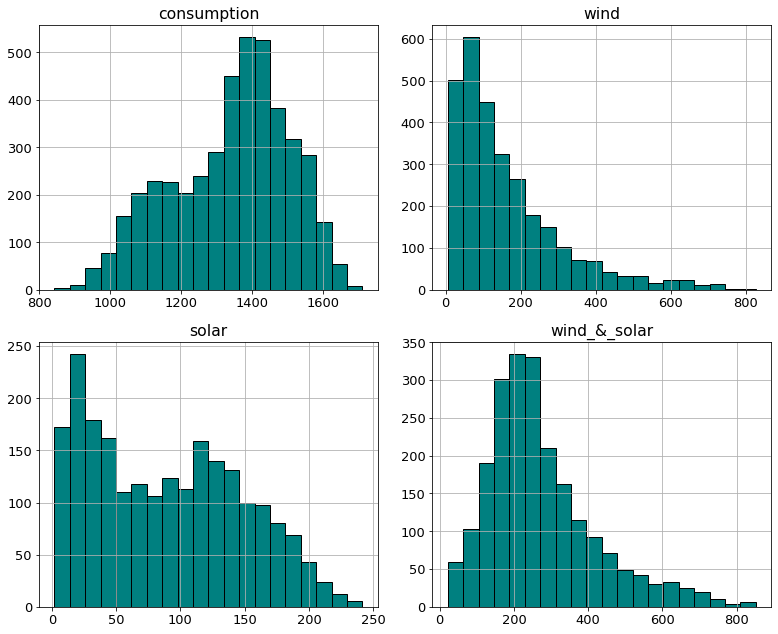

In [6]:
df = prep_german_data(df)

In [7]:
df.head()

,consumption,wind,solar,wind_&_solar,month,year
date,,,,,,
2006-01-01,1069.184,0.0,0.0,0.0,1,2006
2006-01-02,1380.521,0.0,0.0,0.0,1,2006
2006-01-03,1442.533,0.0,0.0,0.0,1,2006
2006-01-04,1457.217,0.0,0.0,0.0,1,2006
2006-01-05,1477.131,0.0,0.0,0.0,1,2006


In [8]:
# Date time already inputed and date is indexed
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   consumption   4383 non-null   float64
 1   wind          4383 non-null   float64
 2   solar         4383 non-null   float64
 3   wind_&_solar  4383 non-null   float64
 4   month         4383 non-null   int64  
 5   year          4383 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 239.7 KB


# Splitting the data¶

In [9]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

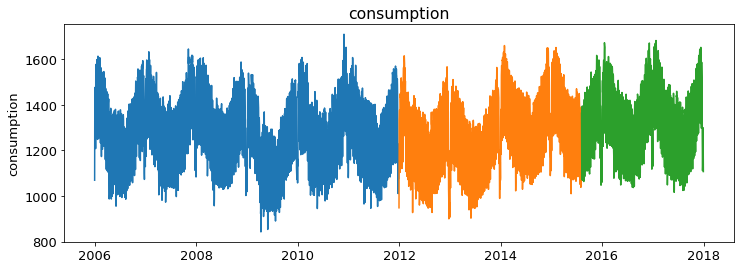

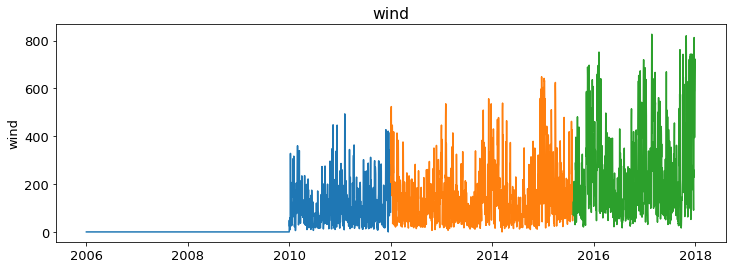

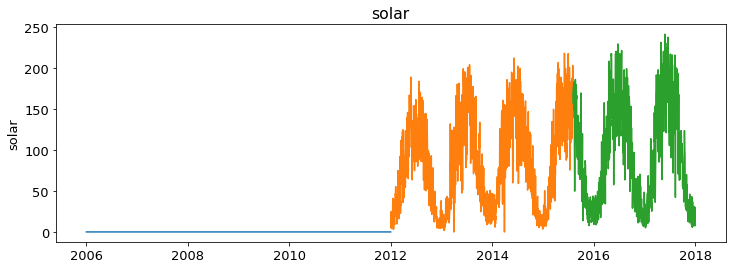

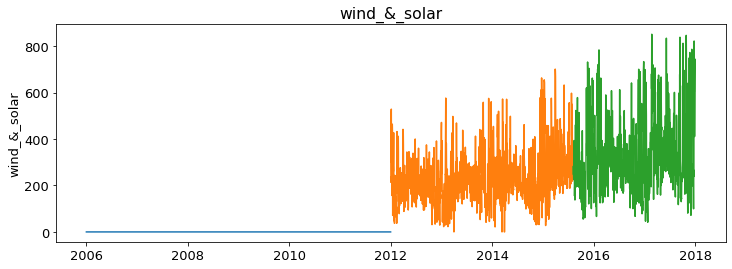

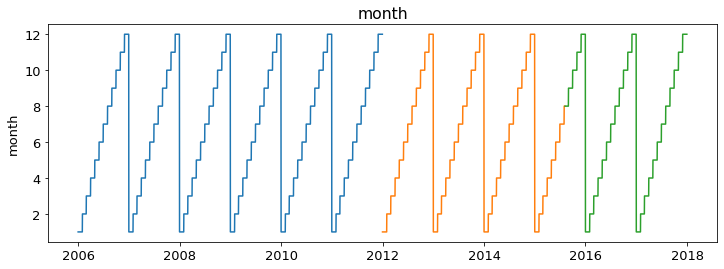

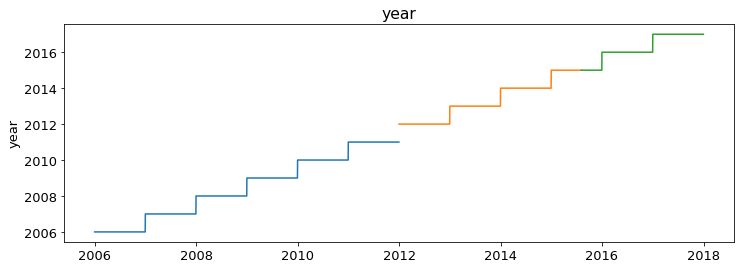

In [10]:
# Based on the graphs, solar started in 2012, going to make data frame to show all data starting with 2012
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [11]:
df= df['2012-01-01':]
df = df.drop(columns =['month','year'])

In [12]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

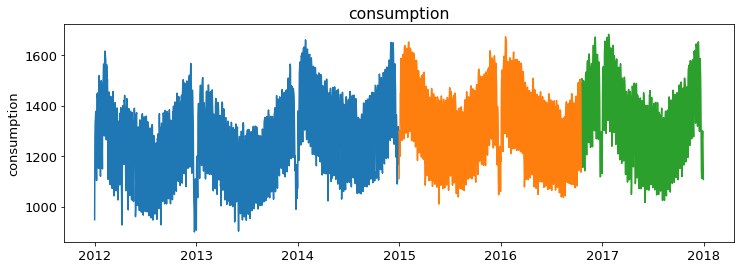

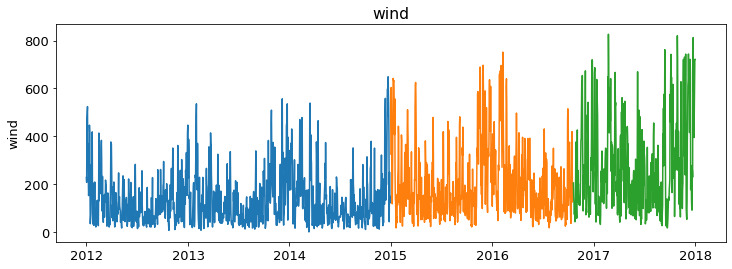

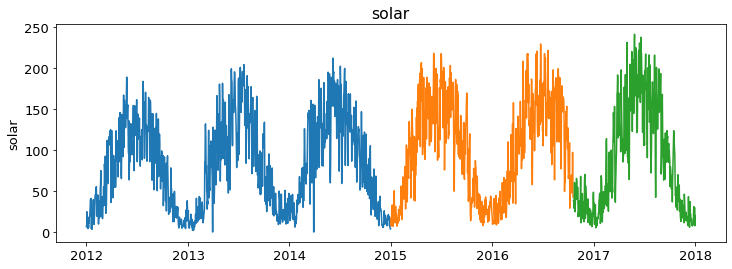

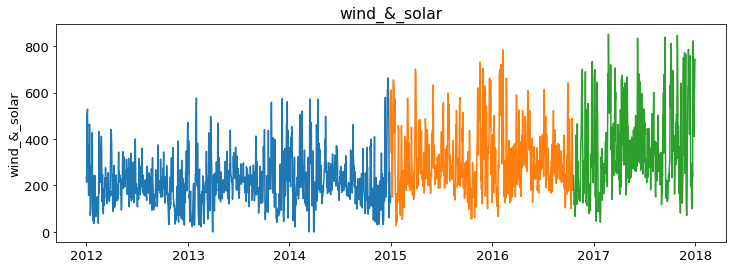

In [13]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [14]:
import wrangle as w

# Forecast
**Last observed value**
The simplest method for forecasting is to predict all future values to be the last observed value.

Make Predictions

In [15]:
#Taking the last 2 values and projecting them foward
train.tail()

,consumption,wind,solar,wind_&_solar
date,,,,
2014-12-27,1198.834,249.906,7.521,257.427
2014-12-28,1168.079,137.846,15.524,153.370
2014-12-29,1316.093,148.966,5.221,154.187
2014-12-30,1300.367,121.775,3.392,125.167
2014-12-31,1183.510,145.511,3.721,149.232


In [16]:
# [-1:] takes the last value consumption [0] selects the value
consumed = round(train['consumption'][-1:][0],2)
w = round(train['wind'][-1:][0],2)
s = round(train['solar'][-1:][0],2)
w_n_s= round(train['wind_&_solar'][-1:][0],2)

In [17]:
# Key is index is the **validate**. All values show the last values choosen
yhat_df = pd.DataFrame({'consumption': [consumed], 'wind': [w], 'solar': [s], 'wind_&_solar': [w_n_s]}, 
                       index = validate.index)

yhat_df.head()

,consumption,wind,solar,wind_&_solar
date,,,,
2015-01-01,1183.51,145.51,3.72,149.23
2015-01-02,1183.51,145.51,3.72,149.23
2015-01-03,1183.51,145.51,3.72,149.23
2015-01-04,1183.51,145.51,3.72,149.23
2015-01-05,1183.51,145.51,3.72,149.23


# Functions to help in modeling

In [18]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [19]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [20]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# You can see, when peeking into yhat_df, that every predicted value is the same.
**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

consumption -- RMSE: 250


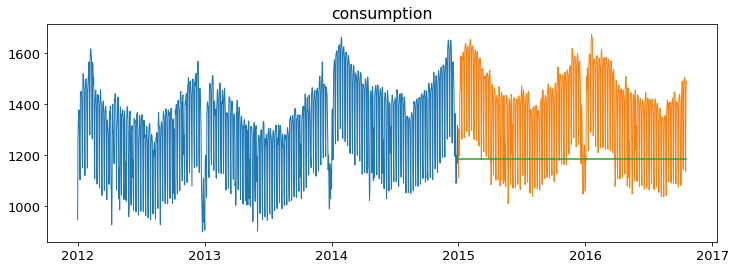

wind -- RMSE: 163


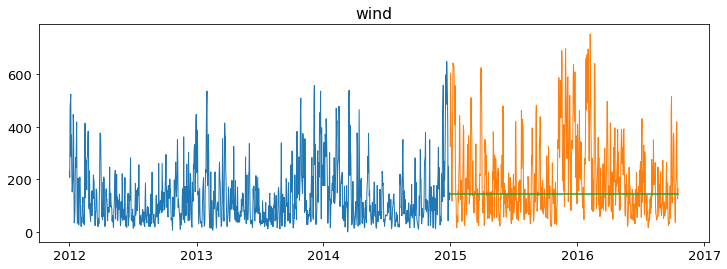

solar -- RMSE: 115


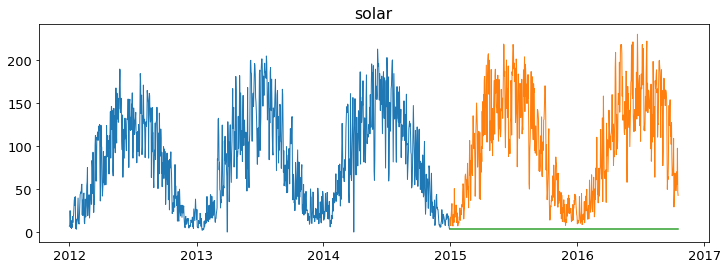

wind_&_solar -- RMSE: 211


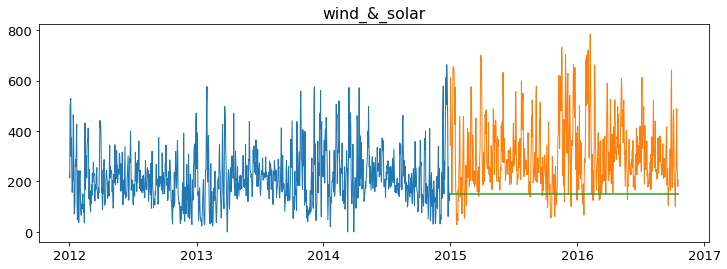

In [21]:
for col in train.columns:
    plot_and_eval(col)

## Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [22]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_obs_value',
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_obs_value,consumption,250.0
1,last_obs_value,wind,163.0
2,last_obs_value,solar,115.0
3,last_obs_value,wind_&_solar,211.0


# Simple Average
Take the simple average of historical values and use that value to predict future values.

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

**Make Predictions**

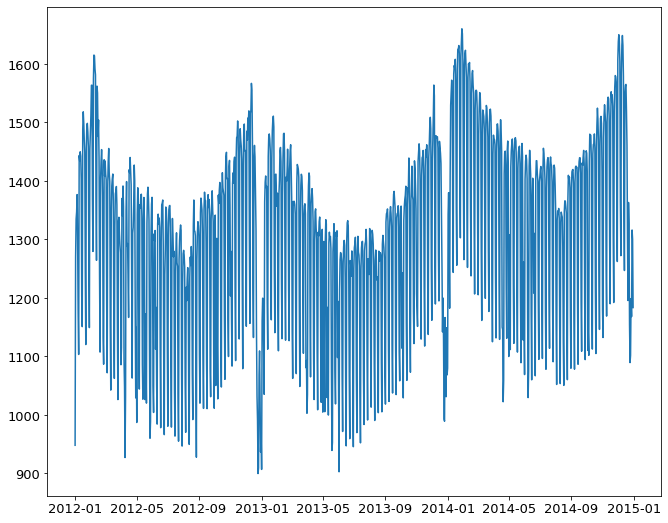

In [23]:
# compute the simple AVG for consumption
plt.plot(train['consumption'])
consumed = round(train['consumption'].mean(),2)

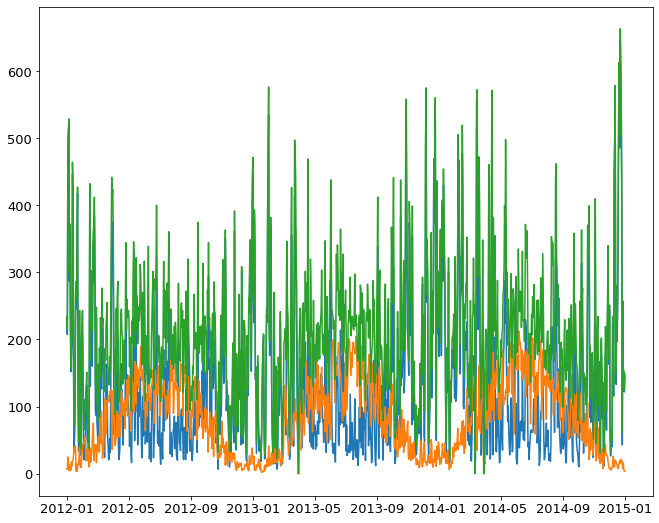

In [24]:
# For wind, solar and wind and solar now. establishing the values of the predictions we will make
plt.plot(train['wind'])
w = round(train['wind'].mean(),2)
plt.plot(train['solar'])
s = round(train['solar'].mean(),2)
plt.plot(train['wind_&_solar'])
w_n_s= round(train['wind_&_solar'].mean(),2)

In [25]:
# Making predictions
def make_predictions():
    yhat_df = pd.DataFrame({'consumption': [consumed], 'wind': [w], 'solar': [s], 'wind_&_solar': [w_n_s]
                           }, index = validate.index)
    return yhat_df

In [26]:
yhat_df = make_predictions()

In [27]:
yhat_df.head()

,consumption,wind,solar,wind_&_solar
date,,,,
2015-01-01,1311.2,131.54,82.07,213.34
2015-01-02,1311.2,131.54,82.07,213.34
2015-01-03,1311.2,131.54,82.07,213.34
2015-01-04,1311.2,131.54,82.07,213.34
2015-01-05,1311.2,131.54,82.07,213.34


### Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using Simple Average

consumption -- RMSE: 172


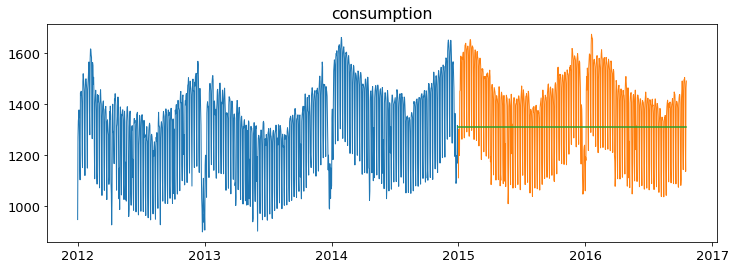

wind -- RMSE: 168


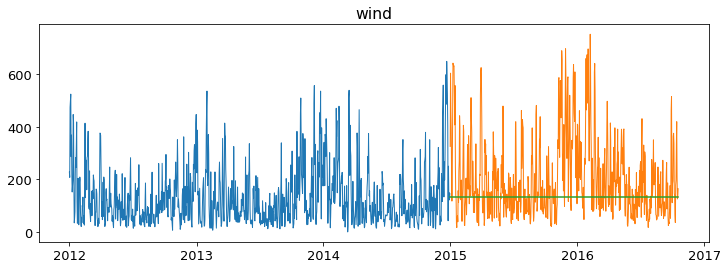

solar -- RMSE: 63


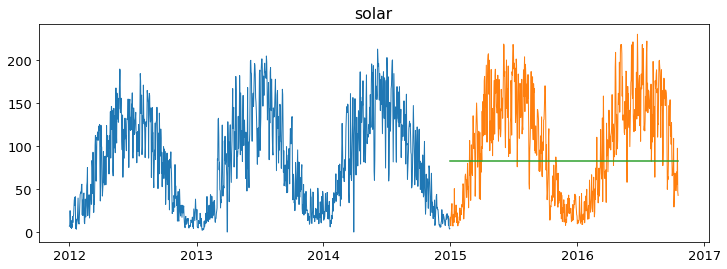

wind_&_solar -- RMSE: 168


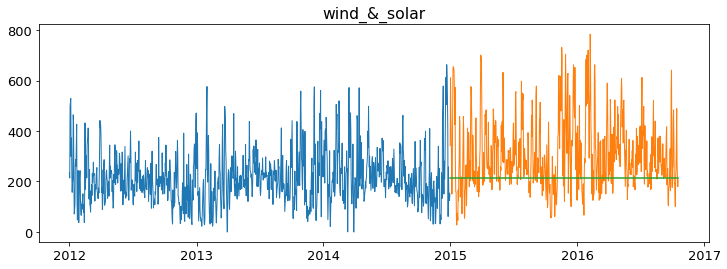

In [28]:
for col in train.columns:
    plot_and_eval(col)

## Evaluate
Evaluate using MSE and RMSE, and add evaluation metrics to eval_df



In [29]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_obs_value,consumption,250.0
1,last_obs_value,wind,163.0
2,last_obs_value,solar,115.0
3,last_obs_value,wind_&_solar,211.0
4,simple_average,consumption,172.0
5,simple_average,wind,168.0
6,simple_average,solar,63.0
7,simple_average,wind_&_solar,168.0


# Moving Average
In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

**Make Predictions**

In [30]:
def moving_avg():
    for col in train.columns:
        plt.figure(figsize=(12,4))
        plt.plot(train[col].rolling(7).mean())
        plt.plot(train[col].rolling(30).mean())
        plt.plot(train[col].rolling(90).mean())
        plt.plot(train[col].rolling(120).mean())
        plt.plot(train[col], alpha = .2)
        plt.show()
        

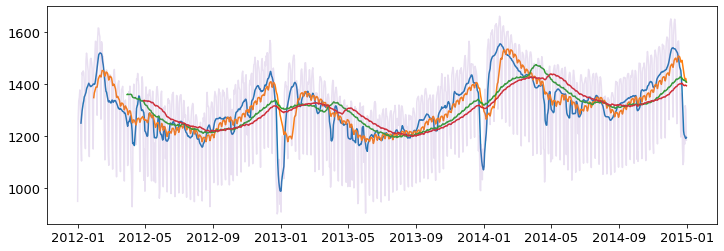

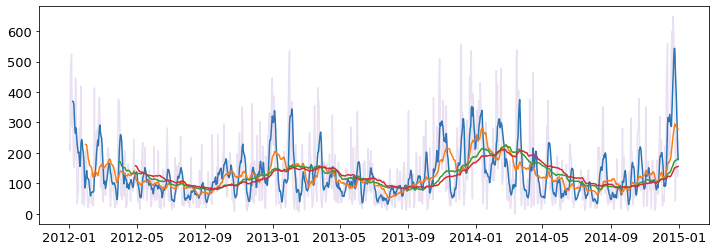

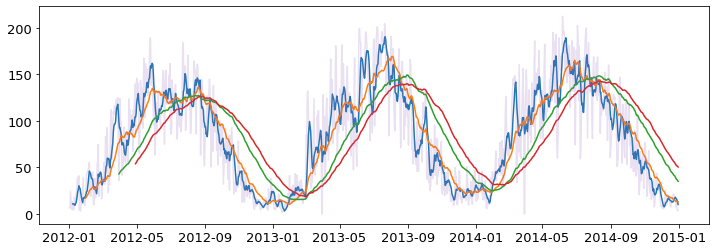

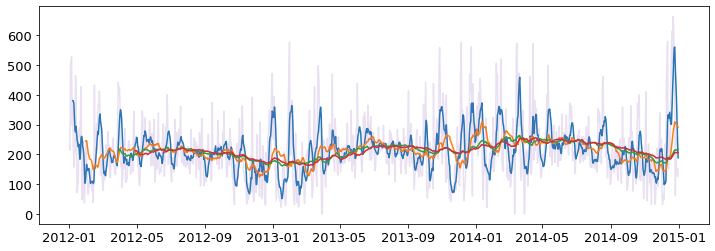

In [31]:
train = moving_avg()

# Make Predicitons


In [34]:
periods = [7, 30, 60, 90, 120]

for p in periods:
    consumed = round(train['consumption'].rolling(p).mean()[-1],2)
    w = round(train['wind'].rolling(p).mean()[-1],2)
    s = round(train['solar'].rolling(p).mean()[-1],2)
    w_n_s= round(train['wind_&_solar'].rolling(p).mean()[-1],2)
    #Uses consumed, w, s, and w_n_s from above to validate
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                 target_var = col
                                )

TypeError: 'NoneType' object is not subscriptable